In [1]:
import os

# webscraping
import requests
from urllib.parse import quote

# data preprocessing
from collections import defaultdict
from itertools import combinations
from tqdm.notebook import tqdm
import json
import re
import pandas as pd

# networks
import networkx as nx
import pickle
import matplotlib.pyplot as plt

# Getting the Player Engagement thru Abyss Rank

In [2]:
data_list = []

for version in range(51, 1 - 1, -1):  # from 51 down to 1
    url = f'https://api.yshelper.com/ys/getAbyssRank.php?star=all&role=all&lang=en&version={version}'
    response = requests.get(url).json()
    version_name = response['version']
    tips = response['tips']

    # Extract Total and Effective samples
    total_match = re.search(r'Total\s*(\d+)', tips)
    effective_match = re.search(r'effective\s*(\d+)', tips, re.IGNORECASE)

    total_samples = total_match.group(1) if total_match else None
    effective_samples = effective_match.group(1) if effective_match else None

    print(f"Version {version}: Total={total_samples}, Effective={effective_samples}")

    data_list.append({
        'Version': version,
        'Version Name': version_name,
        'Total Samples': total_samples,
        'Effective Samples': effective_samples
    })
    
df = pd.DataFrame(data_list)


Version 51: Total=123768, Effective=97455
Version 50: Total=101909, Effective=77793
Version 49: Total=142018, Effective=120354
Version 48: Total=122176, Effective=94710
Version 47: Total=101501, Effective=82521
Version 46: Total=135181, Effective=115539
Version 45: Total=122925, Effective=100758
Version 44: Total=133046, Effective=115692
Version 43: Total=141804, Effective=125490
Version 42: Total=145286, Effective=113505
Version 41: Total=116634, Effective=90414
Version 40: Total=105851, Effective=80802
Version 39: Total=110567, Effective=83133
Version 38: Total=110747, Effective=84540
Version 37: Total=99491, Effective=77727
Version 36: Total=60640, Effective=47748
Version 35: Total=142578, Effective=112266
Version 34: Total=92803, Effective=73653
Version 33: Total=174438, Effective=140676
Version 32: Total=121888, Effective=99096
Version 31: Total=203614, Effective=172554
Version 30: Total=189810, Effective=162231
Version 29: Total=219054, Effective=197346
Version 28: Total=173814, 

In [3]:
samples = ['Total Samples', 'Effective Samples']
for sample_columns in samples:
    df[sample_columns] = pd.to_numeric(df[sample_columns])

df['Patch'] = df['Version Name'].str[9:12]

# I used regex so that i can eventually path label
df['Patch Label'] = df['Version Name'].str.extract(r'(\d\.\d)\(Phase\s+(\w*)\)')\
                                                         .apply(lambda x: ' '.join(x), axis=1)

df = df.iloc[::-1]

df.to_csv('data/abyss_rank_activity.csv', index=False)

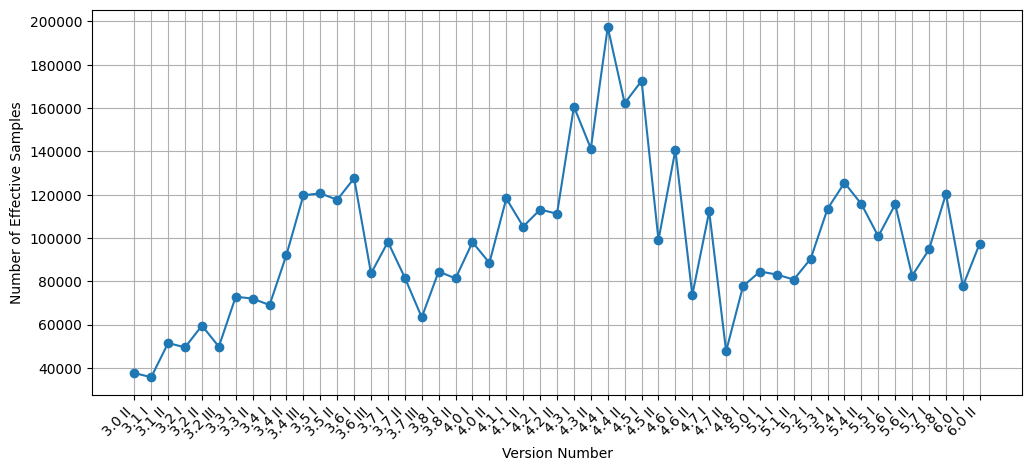

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(df['Version'], df['Effective Samples'], marker='o')
plt.xticks(ticks=df['Version'], labels=df['Patch Label'], rotation=45, ha='right')
plt.xlabel('Version Number')
plt.ylabel('Number of Effective Samples')
plt.grid()
plt.show()

# Getting the Graphs

In [ ]:
with open("data/list_of_names.txt", "r") as file:
    content = file.read()
    data = json.loads(content)

In [4]:
def create_mapping():
    """Creates a mapping from avatar image URLs to English character names."""
    image_english_mapping = {}

    for char_info in data['has_list']:
        name = char_info['name']
        image_link = char_info['avatar']

        # Match Chinese name with English equivalent
        cn_to_ens = data['select_list']
        for cn_to_en in cn_to_ens:
            cn = cn_to_en['title'][:-2]
            if cn == name:
                en = cn_to_en['value']
                image_english_mapping[image_link] = en
                break  # Stop once matched

    # Add default mapping for Traveler
    image_english_mapping.update({
        ('https://upload-bbs.mihoyo.com/game_record/genshin/character_icon/'
         'UI_AvatarIcon_PlayerGirl.png'): 'Traveler'
    })

    return image_english_mapping

image_english_mapping = create_mapping()

In [6]:
# helper function
def get_character_names():
    """Get the character names"""
    url = 'https://api.yshelper.com/ys/getAbyssRank.php'
    data = requests.get(url).json()
    
    char_names = []
    for char_json in data['select_list'][1:]:
        char_names.append(char_json['value'])

    return char_names

char_names = get_character_names()

In [7]:
# helper function
def get_team_usage_per_char(char_name, version):
    """
    Given the character name and version, return the top 100 or fewer 
    teams that include the character (from result[3]).
    """
    base_url = "https://api.yshelper.com/ys/getAbyssRank.php"
    url = (
        f"{base_url}?star=all&role={quote(char_name)}"
        f"&lang=en&version={version}"
    )

    team_data = requests.get(url).json()['result'][3]

    return team_data if team_data else None

In [8]:
# important function
def get_team_per_version(version, char_names):
    """Given the version, get all the possible teams in a list 
    with each elemenet as a json str"""
    possible_teams = set()
    
    # loop over all the characters
    for char in tqdm(char_names, desc="Fetching team usage"):
        # get the teams
        char_team_usage =  get_team_usage_per_char(char, version)
        
        # if there are no teams, then skip this character
        if not char_team_usage:
            continue
            
        # add to a set all the possible teams
        for team in char_team_usage:
            possible_teams.add(json.dumps(team, sort_keys=True))
    return list(possible_teams)

In [9]:
# important function
def get_occur_version(teams, image_english_mapping):
    co_occur = defaultdict(float)
    for team in tqdm(teams, desc="Getting the normalized co-occurence rate"):
        # get the names
        team = json.loads(team)
        char_names = []
        for character_dict in team['role']:
            character = character_dict['avatar']
            char_name = image_english_mapping[character]
            if char_name:  # Only add if mapping is successful
                char_names.append(char_name)
    
        # get each character combination
        for char1, char2 in combinations(sorted(char_names), 2):
            co_occur[(char1, char2)] += team['attend_rate']
            
    return co_occur

In [10]:
# important function
def get_graph(co_occur):
    sorted_list = sorted(co_occur.items(), key=lambda x: x[1], reverse=True)
    filtered_list = [item for item in sorted_list if item[1] >= 1]
    
    co_occur_graph = nx.Graph()
    for char_comb, weight in filtered_list:
        char1, char2 = char_comb[0], char_comb[1]
        co_occur_graph.add_edge(char1, char2, weight=co_occur[(char1, char2)])

    return co_occur_graph

In [11]:
# main function
def create_graph(version, char_names=char_names, image_english_mapping=image_english_mapping):
    possible_teams = get_team_per_version(version, char_names)
    co_occur = get_occur_version(possible_teams, image_english_mapping)
    return get_graph(co_occur)

In [12]:
os.makedirs("graphs", exist_ok=True)

for i in range(7, 0, -1):
    graph = create_graph(i)  # Call your function
    filename = f"graphs/graph_{i}.pickle"  # File path
    # Save the graph using pickle
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)
    print(f"Saved {filename}")

Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2993 [00:00<?, ?it/s]

Saved graphs/graph_7.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2601 [00:00<?, ?it/s]

Saved graphs/graph_6.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2833 [00:00<?, ?it/s]

Saved graphs/graph_5.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2889 [00:00<?, ?it/s]

Saved graphs/graph_4.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2709 [00:00<?, ?it/s]

Saved graphs/graph_3.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate:   0%|          | 0/2411 [00:00<?, ?it/s]

Saved graphs/graph_2.pickle


Fetching team usage:   0%|          | 0/105 [00:00<?, ?it/s]

Getting the normalized co-occurence rate: 0it [00:00, ?it/s]

Saved graphs/graph_1.pickle
